In [9]:
import matplotlib.pyplot as plt

In [10]:
file_path = '/content/plot_data.txt'

In [11]:
# Initialize lists to hold iteration numbers and loss values
iterations = []
losses = []

# Open the file and process each line
with open(file_path, 'r') as file:
    for line in file:
        if line.strip():  # Check if line is not empty
            parts = line.split(',')
            try:
                iteration = int(parts[0].strip())
                loss = float(parts[1].split(':')[1].strip())
                iterations.append(iteration)
                losses.append(loss)
            except ValueError:
                # Handles any lines that don't match the expected format
                pass



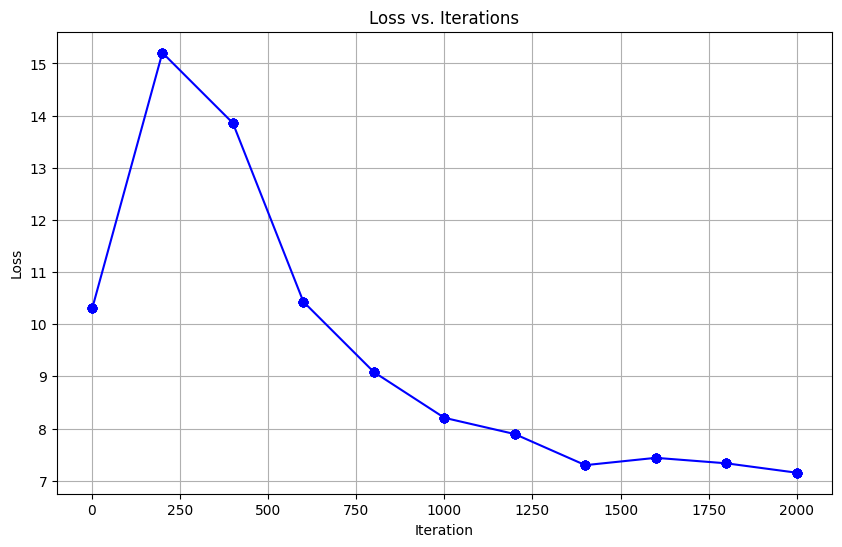

In [12]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(iterations, losses, marker='o', linestyle='-', color='b')
plt.title('Loss vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [13]:
# Function to read data from a file
def read_data(file_path):
    iterations = []
    losses = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.strip():  # Check if line is not empty
                parts = line.split(',')
                try:
                    iteration = int(parts[0].strip())
                    loss = float(parts[1].split(':')[1].strip())
                    iterations.append(iteration)
                    losses.append(loss)
                except ValueError:
                    # Handles any lines that don't match the expected format
                    pass
    return iterations, losses




In [14]:
# File paths
file_path1 = '/content/plot_data.txt'
file_path2 = '/content/plot_data_2.txt'
file_path3 = '/content/plot_data_3.txt'

In [15]:
# Read data from files
iterations1, losses1 = read_data(file_path1)
iterations2, losses2 = read_data(file_path2)
iterations3, losses3 = read_data(file_path3)

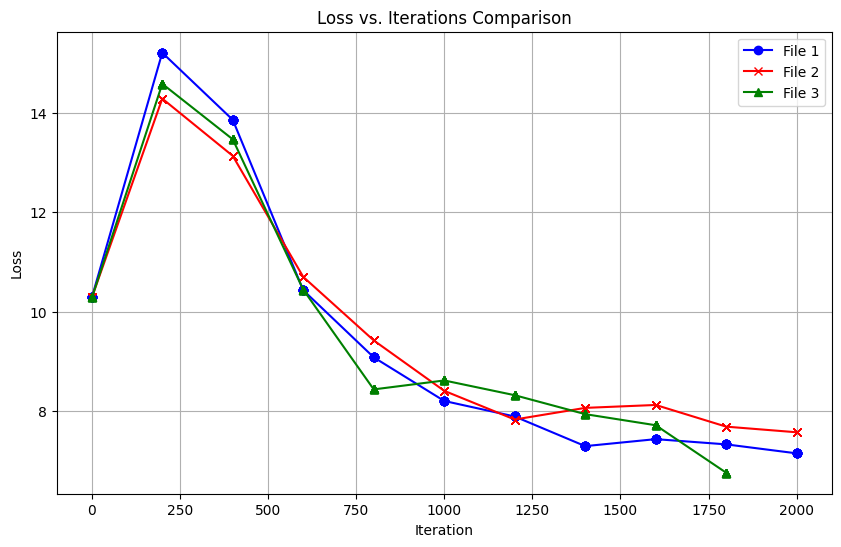

In [16]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(iterations1, losses1, marker='o', linestyle='-', color='b', label='File 1')
plt.plot(iterations2, losses2, marker='x', linestyle='-', color='r', label='File 2')
plt.plot(iterations3, losses3, marker='^', linestyle='-', color='g', label='File 3')

# titles and labels
plt.title('Loss vs. Iterations Comparison')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# View
plt.show()


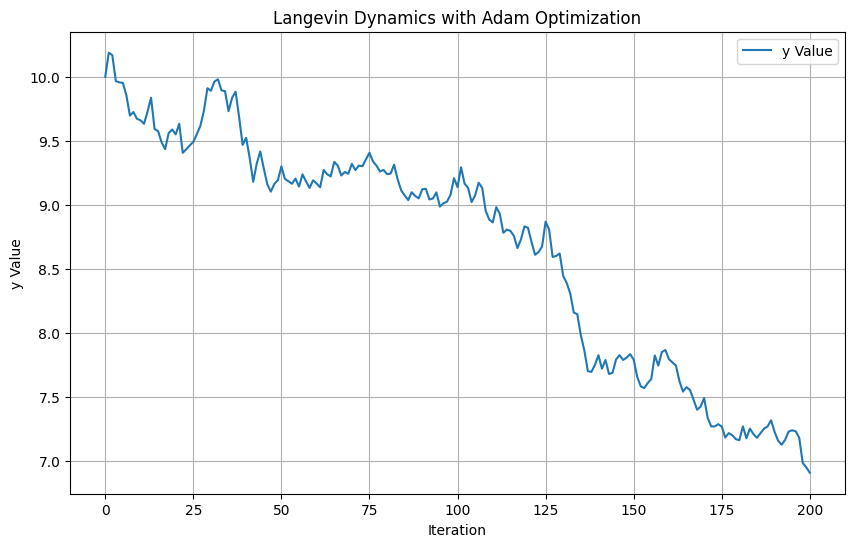

In [17]:
# Import necessary libraries
import torch
import matplotlib.pyplot as plt

# Setting up a toy energy function: E(y) = y^2
def energy_function(y):
    return y.pow(2)

# Gradient of the energy function
def grad_energy_function(y):
    return 2 * y

# Simulating Langevin dynamics with Adam for a simple case
def langevin_dynamics_with_adam(num_iters=100, stepsize=0.1, initial_value=10.0, noise_std=0.1):
    # Initialize y
    y_logits = torch.tensor([initial_value], requires_grad=True)
    # Set up the optimizer
    optim = torch.optim.Adam([y_logits], lr=stepsize)

    # Store values for plotting
    y_values = [y_logits.item()]

    for iter in range(num_iters):
        optim.zero_grad()

        # Compute the energy and its gradient
        energy = energy_function(y_logits)
        energy.backward()

        # Update parameters using Adam
        optim.step()

        # Add noise
        noise = torch.normal(mean=0, std=noise_std, size=y_logits.size())
        with torch.no_grad():  # Ensure no gradient tracking for the noise addition
            y_logits += noise

        # Store values for plotting
        y_values.append(y_logits.item())

    return y_values

# Run the simulation
num_iters = 200
y_values = langevin_dynamics_with_adam(num_iters=num_iters, stepsize=0.01, initial_value=10.0, noise_std=0.1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(num_iters+1), y_values, label='y Value')
plt.xlabel('Iteration')
plt.ylabel('y Value')
plt.title('Langevin Dynamics with Adam Optimization')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
import torch

# Simplified arguments for demonstration
class Args:
    prefix_length = 0
    stepsize = 0.01
    stepsize_iters = 10
    stepsize_ratio = 0.5
    num_iters = 100
    constraint_weight = 0.1
    lr_nll_portion = 0.7
    noise_iters = 5
    large_noise_iters = '25,50,75'
    large_gs_std = '0.5,0.3,0.1'
    gs_std = 0.05
    gs_mean = 0.0
    win_anneal_iters = -1  # Not using windowed annealing in this toy example


In [20]:

# Initialize simplified args
args = Args()

# Initialize logits (simulating starting parameters of a model)
init_logits = torch.tensor([0.5], requires_grad=True)
prefix_logits = torch.tensor([0.1], requires_grad=True)  # Not used in this toy example

# Setting up the optimizer and scheduler
epsilon = torch.nn.Parameter(torch.zeros_like(init_logits))
optim = torch.optim.Adam([epsilon] + ([prefix_logits] if args.prefix_length > 0 else []), lr=args.stepsize)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim, step_size=args.stepsize_iters, gamma=args.stepsize_ratio)

for iter in range(args.num_iters):
    optim.zero_grad()

    # Simulate y_logits modification based on epsilon (parameter update simulation)
    y_logits_ = init_logits + epsilon

    # Toy loss computation (Replace with actual loss computation in your task)
    # This is just a placeholder to mimic the process of loss calculation
    lr_nll_loss = y_logits_.pow(2).sum()  # Simulating a part of the loss based on current logits
    rl_nll_loss = (y_logits_ - 1).pow(2).sum()  # Another part of the simulated loss
    c_loss = (epsilon.pow(2).sum())  # Constraint loss based on epsilon

    # Combine losses with weights
    loss = (1.0 - args.constraint_weight) * args.lr_nll_portion * lr_nll_loss \
           + (1.0 - args.constraint_weight) * (1 - args.lr_nll_portion) * rl_nll_loss \
           + args.constraint_weight * c_loss
    loss = loss.mean()

    # Backpropagation and optimization step
    if iter < args.num_iters - 1:
        loss.backward()
        optim.step()
        scheduler.step()

    # Noise injection for exploration
    if iter < args.num_iters - 1 and iter % args.noise_iters == 0:
        noise_std = args.gs_std  # Default noise standard deviation
        # Adjust noise_std based on iteration number
        for ni, large_noise_iter in enumerate(map(int, args.large_noise_iters.split(','))):
            if iter < large_noise_iter:
                noise_std = float(args.large_gs_std.split(',')[ni])
                break

        # Generate and apply noise
        noise = torch.normal(mean=args.gs_mean, std=noise_std, size=epsilon.size())
        with torch.no_grad():
            epsilon += noise

    print(f"Iteration {iter+1}, Loss: {loss.item():.4f}, Epsilon: {epsilon.item():.4f}")

# Note: In a real NLP task, y_logits_ would represent the adjusted logits of your model's output,
# and you'd use actual NLP-related loss calculations instead of the toy loss used here.


Iteration 1, Loss: 0.2250, Epsilon: 0.3446
Iteration 2, Loss: 0.4678, Epsilon: 0.3354
Iteration 3, Loss: 0.4582, Epsilon: 0.3258
Iteration 4, Loss: 0.4485, Epsilon: 0.3161
Iteration 5, Loss: 0.4387, Epsilon: 0.3063
Iteration 6, Loss: 0.4290, Epsilon: -0.1271
Iteration 7, Loss: 0.1954, Epsilon: -0.1359
Iteration 8, Loss: 0.1945, Epsilon: -0.1440
Iteration 9, Loss: 0.1939, Epsilon: -0.1512
Iteration 10, Loss: 0.1934, Epsilon: -0.1578
Iteration 11, Loss: 0.1931, Epsilon: -0.3601
Iteration 12, Loss: 0.2250, Epsilon: -0.3624
Iteration 13, Loss: 0.2259, Epsilon: -0.3641
Iteration 14, Loss: 0.2265, Epsilon: -0.3652
Iteration 15, Loss: 0.2269, Epsilon: -0.3658
Iteration 16, Loss: 0.2271, Epsilon: -0.9656
Iteration 17, Loss: 0.8098, Epsilon: -0.9644
Iteration 18, Loss: 0.8079, Epsilon: -0.9623
Iteration 19, Loss: 0.8046, Epsilon: -0.9594
Iteration 20, Loss: 0.8001, Epsilon: -0.9561
Iteration 21, Loss: 0.7949, Epsilon: -1.1388
Iteration 22, Loss: 1.1120, Epsilon: -1.1367
Iteration 23, Loss: 1.10

In [24]:
import torch

# Simplify the setup
num_iters = 5  # Number of iterations for demonstration
stepsize = 0.1  # Learning rate for Adam optimizer
init_value = 0.5  # Initial value for y_logits

# Initialize y_logits and epsilon
y_logits = torch.tensor([init_value], requires_grad=True)
epsilon = torch.nn.Parameter(torch.zeros_like(y_logits))

# Setup optimizer
optim = torch.optim.Adam([epsilon], lr=stepsize)

print(f"Initial y_logits: {y_logits.item()}, Dimension: {y_logits.dim()}")
print(f"Initial epsilon: {epsilon.item()}, Dimension: {epsilon.dim()}")

for iter in range(num_iters):
    optim.zero_grad()  # Clear gradients

    # Simulate y_logits update by adding epsilon
    y_logits_ = y_logits + epsilon
    print(f"\nIteration {iter+1}:")
    print(f"y_logits_ (y_logits + epsilon): {y_logits_.item()}")

    # Toy loss function: (y_logits_)^2
    loss = y_logits_.pow(2)
    print(f"Loss: {loss.item()}")

    # Compute gradients
    loss.backward()
    print(f"Gradient of epsilon w.r.t. loss: {epsilon.grad.item()}")

    # Step the optimizer (updates epsilon based on its gradient)
    optim.step()

    # Print updated epsilon after optimization step
    print(f"Updated epsilon after optim step: {epsilon.item()}")

print("\n")
print("Explanation:")
print(f"Adam optimizer adjusts `epsilon` based on its calculated gradients, aiming to minimize the loss. It uses adaptive learning rates for each parameter (here, just `epsilon`), considering the history of gradients to make updates. This helps in efficiently finding the minimum of the loss function over iterations.")


Initial y_logits: 0.5, Dimension: 1
Initial epsilon: 0.0, Dimension: 1

Iteration 1:
y_logits_ (y_logits + epsilon): 0.5
Loss: 0.25
Gradient of epsilon w.r.t. loss: 1.0
Updated epsilon after optim step: -0.09999998658895493

Iteration 2:
y_logits_ (y_logits + epsilon): 0.4000000059604645
Loss: 0.1600000113248825
Gradient of epsilon w.r.t. loss: 0.800000011920929
Updated epsilon after optim step: -0.1988125741481781

Iteration 3:
y_logits_ (y_logits + epsilon): 0.3011874258518219
Loss: 0.09071386605501175
Gradient of epsilon w.r.t. loss: 0.6023748517036438
Updated epsilon after optim step: -0.2951287627220154

Iteration 4:
y_logits_ (y_logits + epsilon): 0.20487123727798462
Loss: 0.04197222366929054
Gradient of epsilon w.r.t. loss: 0.40974247455596924
Updated epsilon after optim step: -0.38708463311195374

Iteration 5:
y_logits_ (y_logits + epsilon): 0.11291536688804626
Loss: 0.012749879620969296
Gradient of epsilon w.r.t. loss: 0.22583073377609253
Updated epsilon after optim step: -0.4